# Results of experiments
- compare interpretations of EBM, GAMI-Net, maybe SNAM (hard to compare)
- plot shape functions
- plot variable importances (for SNAM, it could be only which ones were selected)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['lines.color']='k'
mpl.rcParams['lines.linestyle']='solid'
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "axes.titlepad": 10
})

%matplotlib inline
mpl.style.use('seaborn')

import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from src.gaminet.utils import feature_importance_visualize
from src.ebm.plot import plot_shape_function, importance_bar_chart
from src.plot_all import ebm_plot_all
from src.ebm.train import load_pickled_object, save_pickled_object

In [2]:
### load interpreation data
ebm_dir = 'models/ebm/'
gaminet_dir = 'models/gaminet/'
figure_dir = 'figures/results/'

feature_names = load_pickled_object(f'{ebm_dir}feature_names_all.pkl')

# load raw data from ebm, gaminet, snam, i.e. feature importances, shape functions

shape_data_ebm = load_pickled_object(f'{ebm_dir}158_shape_data.pkl')

feature_importance_ebm = pd.read_pickle(f'{ebm_dir}158_feature_importance_df.pkl')

explain_data_gaminet = np.load(f'{gaminet_dir}162_global_explain.npy', allow_pickle=True)
explain_data_gaminet = explain_data_gaminet[()]

In [3]:
feature_names_latex_dict = {}
feature_names

Index(['cum_return_1_0', 'cum_return_6_2', 'cum_return_12_2',
       'cum_return_12_7', 'cum_return_36_13', 'investment', 'd_ceq', 'dpi2a',
       'd_shrout', 'ivc', 'noa', 'ato', 'cto', 'd_dgm_dsales', 'eps', 'ipm',
       'pcm', 'pm', 'pm_adj', 'prof', 'rna', 'roa', 'roc', 'roe', 'roic',
       's2c', 'sat', 'at_adj', 'aoa', 'ol', 'tan', 'oa', 'a2me', 'beme',
       'beme_adj', 'c', 'c2d', 'd_so', 'debt2p', 'e2p', 'free_cf', 'ldp',
       'nop', 'o2p', 'q', 's2p', 'sales_g', 'at', 'beta', 'beta_daily', 'dto',
       'idio_vol', 'lme', 'lme_adj', 'lturnover', 'rel_to_high_price',
       'ret_max', 'spread_mean', 'std_turn', 'std_volume', 'suv', 'total_vol',
       'ret', 'yy', 'mm_cos', 'mm_sin', 'stock'],
      dtype='object')

## Shape functions

### EBM

issues: 
- has to separate individual and pairwise effects
- variable names are a bit criptic -> convert to latex-ready format

In [4]:
# define a function that replaces a variable name with latex-readable name
def variable_name_to_latex(effect_name):
    """
    Converts Variable names to latex-ready format
    """
    # hard-coded mapping dict
    latex_mapping_dict = {  'cum_return_1_0': 'r_{2-1}', 'cum_return_6_2': 'r_{6-2}', 'cum_return_12_2': 'r_{12-2}',
                        'cum_return_12_7': 'r_{12-7}', 'cum_return_36_13': 'r_{36-13}', 'investment': 'Investment',
                        'd_ceq': '\Delta CEQ', 'dpi2a': '\Delta PI2A', 'd_shrout': '\Delta Shrout',
                        'ivc': 'IVC', 'noa': 'NOA', 'ato': 'ATO', 'cto': 'CTO', 
                        'd_dgm_dsales': '\Delta(\Delta GM-\Delta Sales)', 'eps': 'EPS',
                        'ipm': 'IPM', 'pcm': 'PCM', 'pm': 'PM', 'pm_adj': 'PM_{adj}', 'prof': 'Prof',
                        'rna': 'RNA', 'roa': 'ROA', 'roc': 'ROC', 'roe': 'ROE', 'roic': 'ROIC',
                        's2c': 'S2C', 'sat':'SAT', 'at_adj': 'SAT_{adj}', 'aoa': 'AOA', 'ol': 'OL',
                        'tan': 'Tan', 'oa':'OA', 'a2me': 'A2ME', 'beme': 'BEME', 'beme_adj': 'BEME_{adj}',
                        'c': 'C', 'c2d': 'C2D', 'd_so': '\Delta SO', 'debt2p': 'Debt2P', 'e2p': 'E2P',
                        'free_cf': 'Free CF', 'ldp': 'LDP', 'nop': 'NOP', 'o2p': 'O2P', 'q': 'Q', 's2p': 'S2P',
                        'sales_g': 'Sales_g', 'at': 'AT', 'beta': 'Beta', 'beta_daily':'Beta daily', 'dto': 'DTO',
                        'idio_vol': 'Idio vol', 'lme':' LME', 'lme_adj': 'LME_{adj}', 'lturnover': 'Lturnover', 
                        'rel_to_high_price': 'Rel_to_high_price', 'ret_max': 'Ret_max', 'spread_mean': 'Spread',
                        'std_turn': 'Std turnover', 'std_volume': 'Std volume', 'suv': 'SUV', 'total_vol': 'Total vol',
                        'ret': 'Return', 'yy': 'Year', 'mm_cos':'Month_cos', 'mm_sin': 'Month_sin', 'stock': 'Stock'
                    }

    # for pairwise effects
    if ' x ' in effect_name:
        # substring before sth
        effect_name_left = effect_name[:effect_name.index(" x ")]

        # substring after sth
        effect_name_right = effect_name[effect_name.index(" x ")+3:]
        
        # mapping
        effect_name_left_latex = latex_mapping_dict[effect_name_left]
        effect_name_right_latex = latex_mapping_dict[effect_name_right]
        
        # join substrings
        effect_name_latex = effect_name_left_latex + " x " + effect_name_right_latex
    else:
        # mapping
        effect_name_latex = latex_mapping_dict[effect_name]

    return effect_name_latex

In [5]:
def preprocess_ebm_data(feature_importance_ebm):
    # sort feat importance
    feature_importance_ebm = feature_importance_ebm.sort_values(by='importance score', ascending=False)

    # change col type -> bivariate
    for idx, row in feature_importance_ebm.iterrows():
        #feature_importance_ebm = feature_importance_ebm.copy()
        if ' x ' in row.feature:
            feature_importance_ebm.at[idx, 'type'] = 'bivariate'
            
    # save feature indices by importance -> query shape data dict
    importance_sorted_idx_ebm = feature_importance_ebm.index
    importance_sorted_idx_ebm_top_20 = importance_sorted_idx_ebm[:21]

    # save feature names of top 20 effects -> both main effects and interactions (effects)
    effect_names = feature_importance_ebm['feature'].values
    effect_names_top_20 = effect_names[0:21]
    # to-do: convert effect_names to latex
    effect_names_latex = []
    for name in effect_names:
        name_latex = variable_name_to_latex(name)
        effect_names_latex.append(name_latex)

    return feature_importance_ebm, importance_sorted_idx_ebm, importance_sorted_idx_ebm_top_20, effect_names, effect_names_latex

In [6]:
### Plot all effects in one subplot!
def make_shape_function_grid(model_name, shape_data, importance_sorted_idx, effect_names, save=False, id='0x'):
    """
    Plots a n x n grid where each cell is a single or pairwise shape function.
    """
    # define subplot grid
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    #fig.suptitle(f"{model_name} shape functions", fontsize=18, y=0.95)
    fig.text(0.05, 0.5, 'Variable effect on model output', ha='center', va='center', rotation='vertical', fontsize='x-large')
    fig.text(0.5, 0.05, 'Variable value', ha='center', va='center', rotation='horizontal', fontsize='x-large')

    # loop through ids and axes
    i=0 
    # n_max_interactions = 8 # max interactions to show
    # interaction_count = 0

    for fid, ax in zip(importance_sorted_idx, axs.ravel()):
        # # define the shape function data and feature name for every fid
        single_feature_shape_data = shape_data[fid]
        feature_name = effect_names[i]
        
        if single_feature_shape_data['type']=='interaction': #and interaction_count <= n_max_interactions:
            interaction_shape_data = shape_data[fid]
            # interaction_name = effect_names[i]

            # prepare x and y-labels
            values_left = interaction_shape_data['left_names']
            values_left = [round(elem, 1) for elem in values_left] # round to 2 decimals
            values_right = interaction_shape_data['right_names']
            values_right = [round(elem, 1) for elem in values_right] # round
            value_contrib = interaction_shape_data['scores']
            
            if model_name == 'GAMI-Net':
                values_left = [round(elem) for elem in values_left]
                values_right = [round(elem) for elem in values_right]

            # compute custom tick labels
            num_ticks = 6
            # the index of the position of yticks
            yticks = np.linspace(0, len(values_left) - 1, num_ticks, dtype=np.int32)
            xticks = np.linspace(0, len(values_right) - 1, num_ticks, dtype=np.int32)
            # the content of labels of these yticks
            yticklabels = [values_left[idx] for idx in yticks]
            xticklabels = [values_right[idx] for idx in xticks]
            
            # plot
            ax.set_title(fr'${feature_name}$')        
            sns.heatmap(value_contrib, cmap="Blues", ax=ax, yticklabels=yticklabels, xticklabels=xticklabels)
            ax.invert_yaxis()
            ax.set_yticks(yticks, labels=yticklabels)
            ax.set_xticks(xticks, labels=xticklabels)
        else:
            
            x_vals = single_feature_shape_data["names"].copy()
            y_vals = single_feature_shape_data["scores"].copy()
            
            # plot
            if model_name == 'GAMI-Net':
                ax.plot(x_vals, y_vals)

            else:
                # prepare data
                y_vals = np.r_[y_vals, y_vals[np.newaxis, -1]] 
                x = np.array(x_vals)
                #ax.set_xlim(left=-3, right=3)
                ax.step(x, y_vals, where="post")
            
            #ax.set_xlabel(f'Feature value')
            ax.set_title(fr'${feature_name}$')
            
        i += 1
    if save:
        fig.savefig(f'{figure_dir}{model_name}_shapes_all_{id}.png', bbox_inches='tight', dpi=200)
    plt.show()

In [8]:
feature_importance_ebm, importance_sorted_idx_ebm, importance_sorted_idx_ebm_top_20, effect_names_ebm, effect_names_ebm_latex = preprocess_ebm_data(feature_importance_ebm)

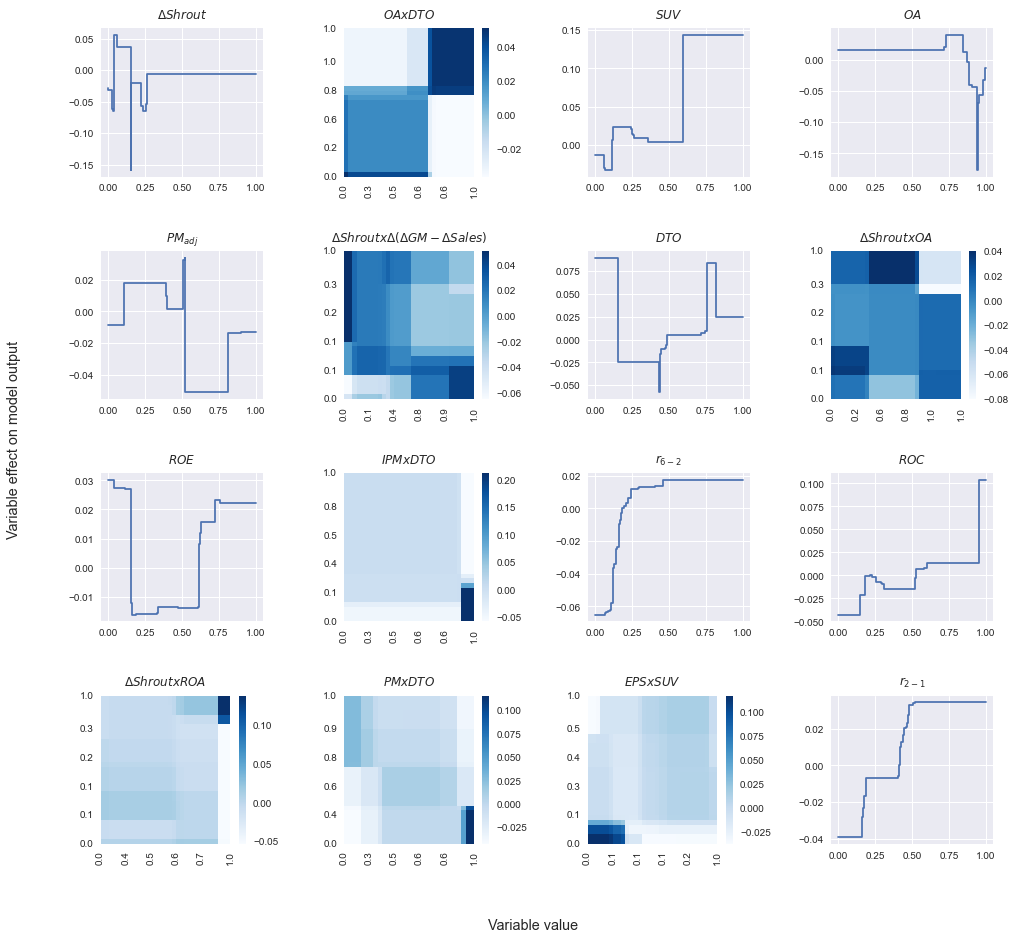

In [9]:
make_shape_function_grid(model_name='EBM', shape_data=shape_data_ebm, importance_sorted_idx=importance_sorted_idx_ebm_top_20, effect_names=effect_names_ebm_latex, save=False, id='158l')

### plot shapes gaminet

Preprocessing goal is to have 
- [x] feat importance df 
- [x] effect names
- shape data dict

like in EBM

In [10]:
# 1) feature importance df
def preprocess_gaminet_data(explain_data_gaminet):
    # extract feat importance from explain_data_gaminet
    feature_importance_gaminet = {'type': [], 'feature': [], 'importance score': []}
    for feature in explain_data_gaminet:
        feature_importance_gaminet['feature'].append(feature) # name
        feature_importance_gaminet['importance score'].append(explain_data_gaminet[feature]['importance']) # imp
        # type
        if 'vs.' in feature:
            feature_importance_gaminet['type'].append('interaction') # bivariate
        else:
            feature_importance_gaminet['type'].append('univariate')
    feature_importance_gaminet = pd.DataFrame(feature_importance_gaminet)

    # sort feat importance
    feature_importance_gaminet = feature_importance_gaminet.sort_values(by='importance score', ascending=False)
        
    # save feature indices by importance -> query shape data dict
    importance_sorted_idx_gaminet = feature_importance_gaminet.index
    #importance_sorted_idx_gaminet_top_20 = importance_sorted_idx_gaminet[:21]

    # 2) feature names of top 20 effects -> both main effects and interactions (effects)
    feature_importance_gaminet['feature'].replace({'vs.': 'x'}, regex=True, inplace=True)
    effect_names_gaminet = feature_importance_gaminet.feature.values
    
    # convert to latex-ready names
    effect_names_latex= []
    for name in effect_names_gaminet:
        # string replace for interactions needed
        effect_name = variable_name_to_latex(name)
        effect_names_latex.append(effect_name)

    #effect_names_gaminet_top_20 = effect_names_gaminet[0:21]

    # 3) shape data gaminet: make it a list of dicts 
    shape_data_gaminet = []

    for feature in explain_data_gaminet:
        if 'vs.' not in feature:
            # main effects: one dict per effect containing (type), inputs, outputs
            single_effect_dict = {}
            single_effect_dict['type'] = 'univariate'
            single_effect_dict['names'] = explain_data_gaminet[feature]['inputs']
            single_effect_dict['scores'] = explain_data_gaminet[feature]['outputs']
            shape_data_gaminet.append(single_effect_dict)
        else:
            # pairwise effects: containing 'input1', 'input2', 'outputs', 'input1_ticks', 'input2_ticks', 'input1_labels', 'input2_labels'
            pairwise_effect_dict = {}
            pairwise_effect_dict['type'] = 'interaction' # bivariate
            pairwise_effect_dict['right_names'] = explain_data_gaminet[feature]['input1']
            pairwise_effect_dict['left_names'] = explain_data_gaminet[feature]['input2']
            pairwise_effect_dict['scores'] = explain_data_gaminet[feature]['outputs']
            # x and y ticks and labels
            pairwise_effect_dict['xticks'] = explain_data_gaminet[feature]['input1_ticks']
            pairwise_effect_dict['yticks'] = explain_data_gaminet[feature]['input2_ticks']
            pairwise_effect_dict['xticklabels'] = explain_data_gaminet[feature]['input1_labels']
            pairwise_effect_dict['yticklabels'] = explain_data_gaminet[feature]['input2_labels']
            shape_data_gaminet.append(pairwise_effect_dict)

    return feature_importance_gaminet, importance_sorted_idx_gaminet, effect_names_gaminet, effect_names_latex, shape_data_gaminet

In [11]:
feature_importance_gaminet, importance_sorted_idx_gaminet, effect_names_gaminet, effect_names_gaminet_latex, shape_data_gaminet = preprocess_gaminet_data(explain_data_gaminet=explain_data_gaminet)

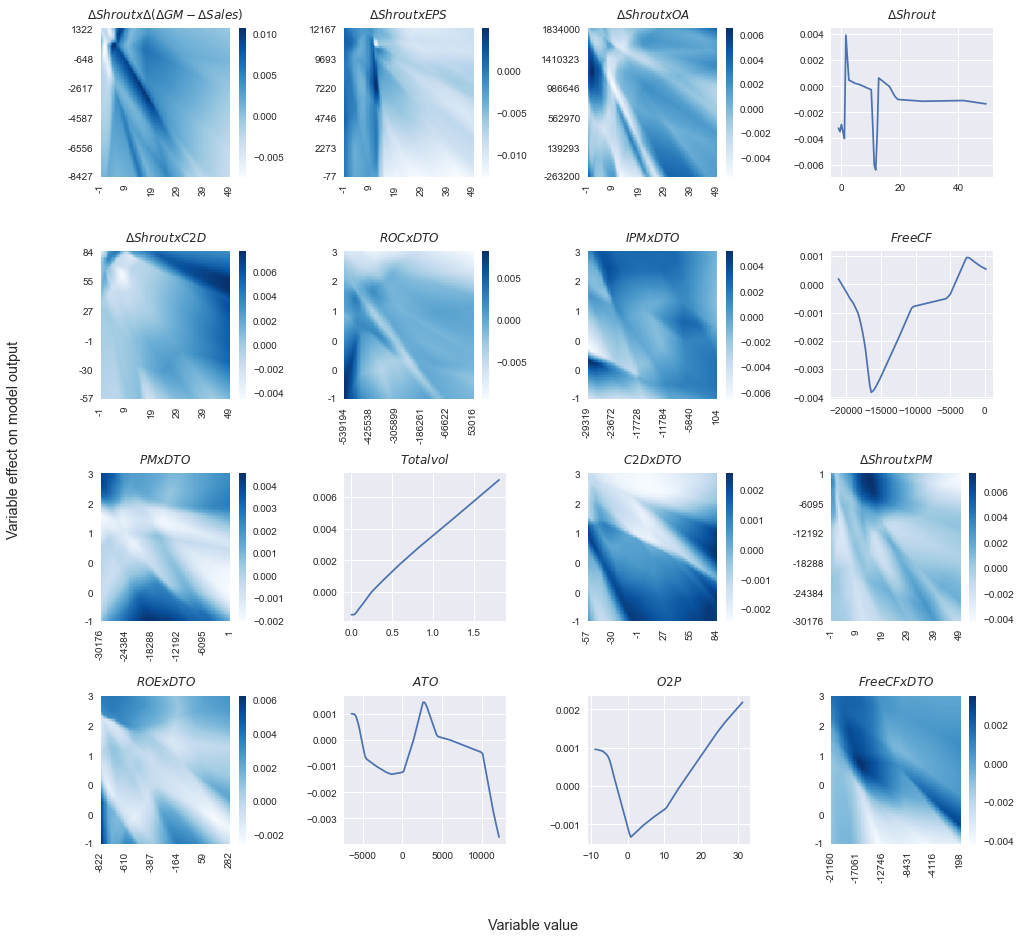

In [80]:
make_shape_function_grid(model_name='GAMI-Net', shape_data=shape_data_gaminet, \
    importance_sorted_idx=importance_sorted_idx_gaminet[:21], effect_names=effect_names_gaminet_latex, save=True, id='162l')

## Plot importances
- use custom bar chart visualization

c:\Users\ASUS\Documents\seminar-interpretable-ml\src\ebm\plot.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_df.sort_values(by='importance score', ascending=False, axis=0, inplace=True)


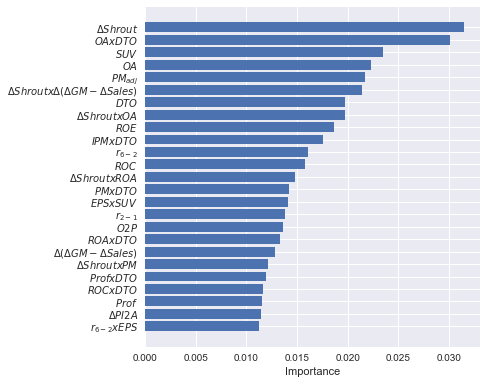

In [14]:
# n_features = feature_importance_ebm[:20].shape[0]
# plt.figure(figsize=(6, 0.25*n_features))
importance_bar_chart(feature_importance_ebm[:25], effect_names=effect_names_ebm_latex[:25], model_dir=figure_dir, model_name='EBM', save=True, id='158l')

In [42]:
# string replace for interactions needed
try:
    feature_importance_gaminet.feature.replace({'vs.': 'x'}, regex=True, inplace=True)
except:
    print('pass')
    pass
feature_importance_gaminet

,type,feature,importance score
78,interaction,d_shrout x d_dgm_dsales,0.166835
70,interaction,d_shrout x eps,0.119311
81,interaction,d_shrout x oa,0.076540
8,univariate,d_shrout,0.075587
67,interaction,d_shrout x c2d,0.057406
...,...,...,...
30,univariate,tan,0.000000
59,univariate,std_volume,0.000000
57,univariate,spread_mean,0.000000
52,univariate,lme,0.000000


c:\Users\ASUS\Documents\seminar-interpretable-ml\src\ebm\plot.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_importance_df.sort_values(by='importance score', ascending=False, axis=0, inplace=True)


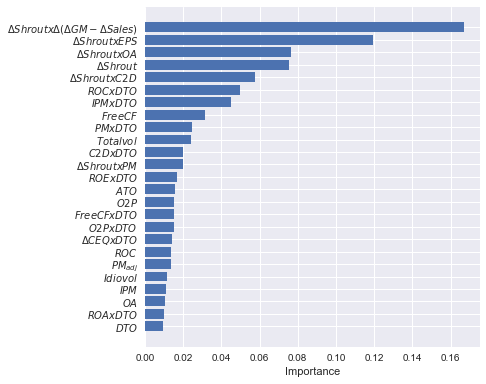

In [15]:
importance_bar_chart(feature_importance_gaminet[:25], effect_names=effect_names_gaminet_latex[:25], model_dir=figure_dir, model_name='GAMI-Net', save=True, id='162l')

In [43]:
# convert feat names for plots
# effect_names_gaminet_list = list(feature_importance_gaminet.feature.values)
# effect_names_ebm_list = effect_names_ebm.tolist()
# effect_names_all = [*effect_names_gaminet_list, *effect_names_ebm_list]
# effect_names_all = list(set(effect_names_all))
# len(effect_names_all)

91

In [65]:
name = 'cum_return_0_1 x roc'
name_latex = variable_name_to_latex(name, latex_mapping_dict)
print(name_latex)

14
r_{2-1} x ROC


In [44]:
print(effect_names_all)

['cum_return_12_2', 'sales_g', 'roe x dto', 'roic x dto', 'eps', 'dto', 'roe', 'd_shrout x d_dgm_dsales', 'beta_daily', 'suv', 'cum_return_6_2 x d_dgm_dsales', 'pcm', 'd_shrout x eps', 'pm_adj', 'ldp', 'spread_mean', 'cum_return_12_7', 'q', 'rel_to_high_price', 'tan', 'std_volume', 'free_cf x dto', 'free_cf', 'd_dgm_dsales x dto', 'ol', 'ret_max', 'd_shrout x pcm', 'aoa', 'debt2p', 'a2me', 'cum_return_6_2', 'noa x dto', 'roc', 'c', 'd_ceq', 'total_vol', 'o2p x dto', 'e2p', 'prof x dto', 'investment', 'roc x dto', 'd_so', 'std_turn', 'stock', 'd_shrout x pm', 'ipm', 'o2p', 'd_shrout x c2d', 's2p', 'cum_return_1_0', 'c2d', 'ato', 's2c', 'd_dgm_dsales', 'beme_adj', 'roa', 'at', 'lme_adj', 'beme', 'oa', 'd_shrout x oa', 'pm', 'ipm x dto', 'cum_return_6_2 x roa', 'ret', 'c2d x dto', 'd_ceq x dto', 'cum_return_6_2 x eps', 'dpi2a', 'sat', 'prof', 'pm x dto', 'd_shrout x roa', 'idio_vol', 'nop', 'roa x dto', 'cum_return_36_13', 'lme', 'noa', 'cto', 'rna', 'ivc', 'at_adj', 'lturnover', 'pm_adj 

### Plot importances using gaminet util-function

- takes `data_dict` as input that needs feature names as keys and `importance` as values

In [21]:
def convert_importances_to_dict(feature_importance_df):
    """ 
    Transforms feature importance data frame into a dictionary 
    that can be used by gaminet function.
    """
    # store feature names and importances as keys/values
    importance_data_dict = {}
    keys = feature_importance_df.feature.to_list()
    values = feature_importance_df['importance score']

    # assign feat names as keys of a dict
    for i in keys:
        importance_data_dict[i] = {} 

    # assign importance as key value pair 
    for key, value in zip(importance_data_dict, values):
        importance_data_dict[key] = {'importance': value}
    return importance_data_dict

importance_data_ebm = convert_importances_to_dict(feature_importance_ebm)
importance_data_gaminet = convert_importances_to_dict(feature_importance_gaminet)

In [9]:
ebm_importance_dict_top_20 = dict(list(importance_data_ebm.items())[:21])
gaminet_importance_dict_top_20 = dict(list(importance_data_gaminet.items())[:21])

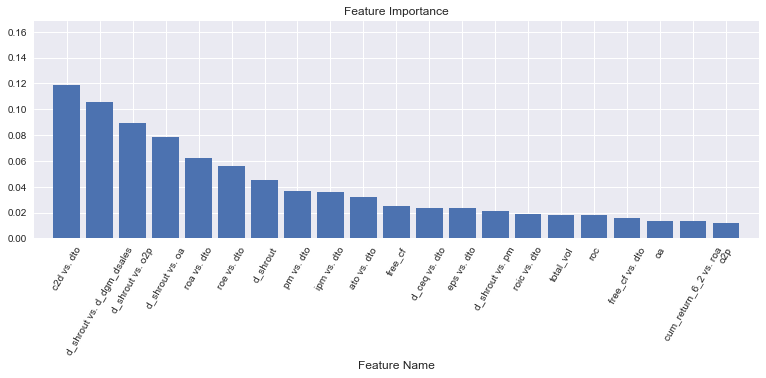

In [ ]:
feature_importance_visualize(gaminet_importance_dict_top_20, folder=figure_dir, name="feature_importance_gaminet_151", save_png=True)

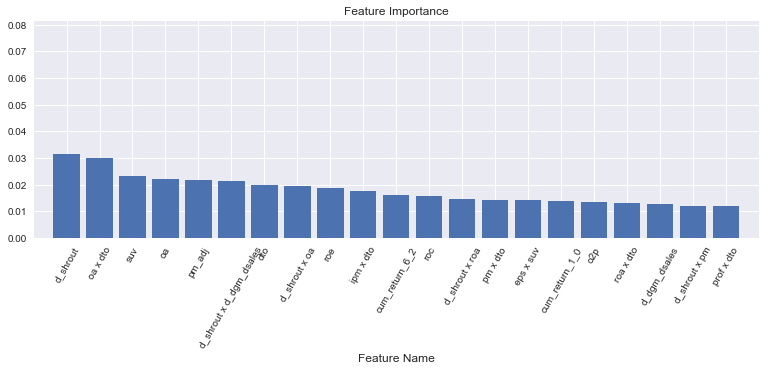

In [ ]:
# plot top 20 shape functions ordered by importance
# TO-DO: plot ebm functions by importance (how?)
feature_importance_visualize(ebm_importance_dict_top_20, folder=figure_dir, name="feature_importance_ebm", save_png=True, save_eps=False)

### Visualize importances via heatmap

In [24]:
fim_gami

78    0.166835
70    0.119311
81    0.076540
8     0.075587
67    0.057406
        ...   
30    0.000000
59    0.000000
57    0.000000
52    0.000000
38    0.000000
Name: gaminet, Length: 84, dtype: float64

In [39]:
feature_names_all = feature_importance_gaminet.feature.append(feature_importance_ebm.feature).unique()
print(feature_names_all)

['d_shrout x d_dgm_dsales' 'd_shrout x eps' 'd_shrout x oa' 'd_shrout'
 'd_shrout x c2d' 'roc x dto' 'ipm x dto' 'free_cf' 'pm x dto' 'total_vol'
 'c2d x dto' 'd_shrout x pm' 'roe x dto' 'ato' 'o2p' 'free_cf x dto'
 'o2p x dto' 'd_ceq x dto' 'roc' 'pm_adj' 'idio_vol' 'ipm' 'oa'
 'roa x dto' 'dto' 'ret' 'c2d' 'pm' 'd_dgm_dsales' 'pm_adj x dto'
 'eps x dto' 'prof' 'noa x dto' 'lturnover' 'roe' 'prof x dto' 'suv'
 'cum_return_1_0' 'sales_g' 'd_so' 'dpi2a' 'cum_return_6_2' 'eps'
 'rel_to_high_price' 'ol' 'at_adj' 'investment' 'roic x dto' 'q' 'beme'
 'ret_max' 'd_ceq' 'cum_return_12_2' 'nop' 'ldp' 'c' 'cum_return_12_7'
 'noa' 'std_turn' 'pcm' 'beta' 'beta_daily' 'beme_adj' 'a2me'
 'cum_return_36_13' 's2p' 'd_shrout x pcm' 'at' 'ivc' 'cto' 'roa' 'rna'
 'lme_adj' 'roic' 's2c' 'sat' 'stock' 'aoa' 'e2p' 'tan' 'std_volume'
 'spread_mean' 'lme' 'debt2p' 'oa x dto' 'd_shrout x roa' 'eps x suv'
 'cum_return_6_2 x eps' 'd_dgm_dsales x dto' 'cum_return_6_2 x roa'
 'cum_return_6_2 x d_dgm_dsales']


C:\Users\ASUS\AppData\Local\Temp\ipykernel_14092\3876691246.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  feature_names_all = feature_importance_gaminet.feature.append(feature_importance_ebm.feature).unique()


In [33]:
# string replace for interactions needed
try:
    feature_importance_gaminet.feature.replace({'vs.': 'x'}, regex=True, inplace=True)
except:
    print('pass')
    pass
feature_importance_gaminet


# draw heatmap to visualize feature importances
fim_gami = feature_importance_gaminet.iloc[:,2]
fim_ebm = feature_importance_ebm.iloc[:,2]
fim_gami = fim_gami.rename('gaminet')
fim_ebm = fim_ebm.rename('ebm')
importance_df = pd.DataFrame([fim_gami, fim_ebm]).transpose()
feature_names = feature_names_all[importance_df.index]


#feature_names = 
plt.figure(figsize=(6,18))
sns.heatmap(importance_df, cmap='Blues', yticklabels=feature_names_all)

IndexError: index 78 is out of bounds for axis 0 with size 67

## Next steps:
- bring ebm importances to same scale as gaminet so that importances add up to 1.
- compare results with literature, i.e. freyberger
- write the paper!!!
- retrain ebm on normalized data (0;1) and compare results
- train gaminet from scratch on whole dataset for a few epochs and continue training on subsample for "fine tuning" 